In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymysql

db = pymysql.connect(host = "localhost",
                     user = "root",
                     password = "Kankana_09#",
                     database = "Ecommerce")

cur = db.cursor()

# *List all unique cities where customers are located*

In [28]:
query = """ select distinct customer_city from customers """
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# *Count the numeber of orders placed in 2017*

In [6]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data = cur.fetchall()
"Total orders placed in 2017 are" , data[0][0]



('Total orders placed in 2017 are', 45101)

# *Find the total sales per category*

In [12]:
query = """ select upper(products.product_category) category, round(sum(payments.payment_value),2) sales from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category"""
cur.execute(query)
data = cur.fetchall()

df=pd.DataFrame(data,columns=["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# *Calculate the percentage of orders that were paid in installments.*

In [16]:
query = """select (sum(case when payment_installments >=1 then 1 else 0 end))/(count(*))*100
from payments"""
cur.execute(query)
data = cur.fetchall()

"the percentage of orders that were paid in installments is" ,data

('the percentage of orders that were paid in installments is',
 ((Decimal('99.9981'),),))

# *Count the number of customers from each state.*

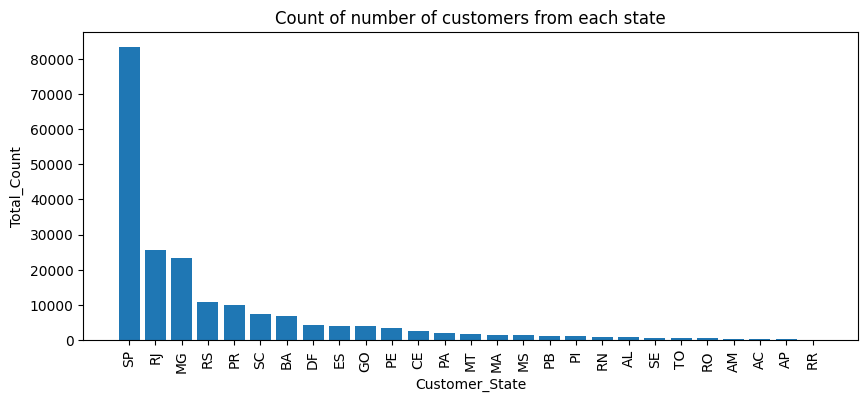

In [35]:
query = """ Select customer_state,count(customer_id) from customers
group by customer_state"""
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=["Customer_State","Total_Count"])
df = df.sort_values(by = "Total_Count",ascending= False)
plt.figure(figsize = (10,4))
plt.bar(df["Customer_State"],df["Total_Count"])
plt.xticks(rotation = 90)
plt.xlabel("Customer_State")
plt.ylabel("Total_Count")
plt.title("Count of number of customers from each state")
plt.show()

# *Calculate the number of orders per month in 2018.*

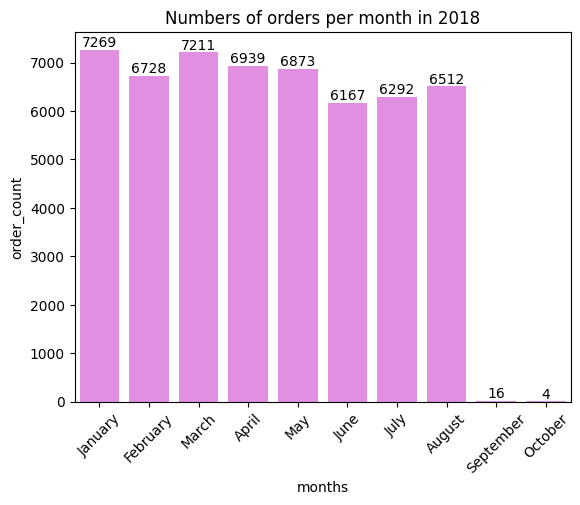

In [ ]:
query = """select monthname(order_purchase_timestamp) months,count(order_id) order_count
from orders where year(order_purchase_timestamp)= 2018 group by months"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["months","order_count"])
o = ["January","February","March","April","May","June","July","August","September","October"]
ax = sns.barplot(x=df["months"],y=df["order_count"],data=df,order = o, color= 'violet')
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Numbers of orders per month in 2018")
plt.show()

# *Find the average number of products per order, grouped by customer city.*

In [8]:
query = """with count_per_order as 
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items on orders.order_id = order_items.order_id
group by orders.order_id ,orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order 
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ["Customer_city","Average"])
df.head(10)


,Customer_city,Average
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,curralinho,4.00
7,picarra,4.00
8,morro de sao paulo,4.00
9,teixeira soares,4.00


# *Calculate the percentage of total revenue contributed by each product category.*

In [27]:
query = """ select upper(products.product_category) category, CONCAT(ROUND((SUM(payments.payment_value) / (SELECT SUM(payment_value) FROM payments)) * 100, 2), '%') sales from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category ORDER BY CAST(REPLACE(sales, '%', '') AS DECIMAL(10,2)) DESC;"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns =["category","Percentage_distribution"])
df.head(10)

,category,Percentage_distribution
0,BED TABLE BATH,10.7%
1,HEALTH BEAUTY,10.35%
2,COMPUTER ACCESSORIES,9.9%
3,FURNITURE DECORATION,8.93%
4,WATCHES PRESENT,8.93%
5,SPORT LEISURE,8.7%
6,HOUSEWARES,6.84%
7,AUTOMOTIVE,5.32%
8,GARDEN TOOLS,5.24%
9,COOL STUFF,4.87%


# *Identify the correlation between product price and the number of times a product has been purchased.*

In [35]:
query = """ select  products.product_category,count(order_items.product_id) , round(avg(order_items.price),2)from products join 
order_items on  products.product_id = order_items.product_id
group by products.product_category;"""
cur.execute(query)
data = cur.fetchall()

df=pd.DataFrame(data,columns=["category","order_count","price"])
arr1 = df["order_count"]
arr2 = df["price"]
a= np.corrcoef([arr1,arr2])
print("The correlation between price and number of times a product has been purchased is ",a[0][1])
                

The correlation between price and number of times a product has been purchased is  -0.10631514167157562


# *Calculate the total revenue generated by each seller, and rank them by revenue.*

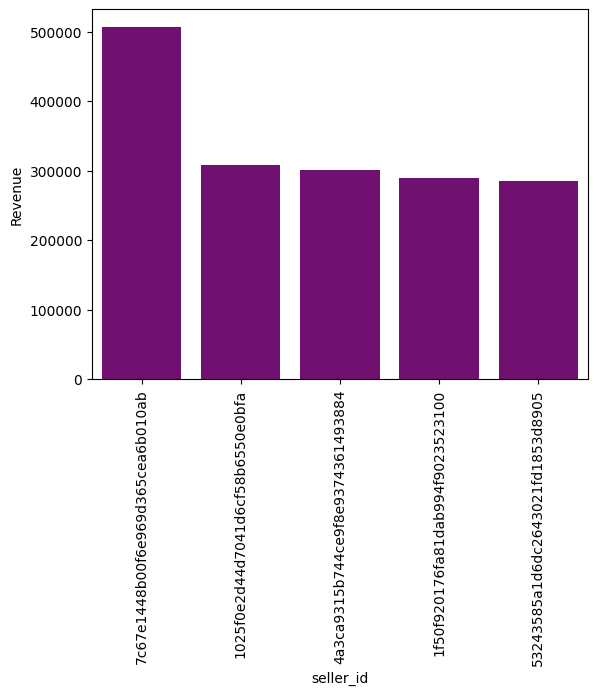

In [45]:
query = """select *,dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id,sum(payments.payment_value) revenue
from order_items join payments on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["seller_id","Revenue","Rank"])
df = df.head(5)
sns.barplot(x="seller_id",y="Revenue",data=df,color="purple")
plt.xticks(rotation = 90)
plt.show()

# *Calculate the moving average of order values for each customer over their order history.*

In [51]:
query = """select customer_id,order_purchase_timestamp,payment,
avg(payment) over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value  as payment from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=["cutomer_id","Time_stamp","price","moving_avg"])
df

,cutomer_id,Time_stamp,price,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# *Calculate the cumulative sales per month for each year.*

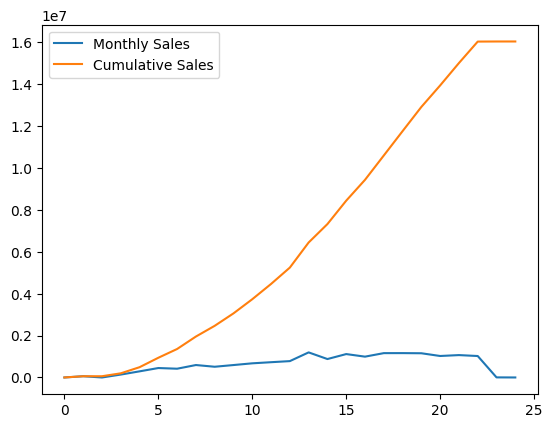

In [ ]:
query = """select years,months,payment,sum(payment)
over(order by years , months) cumulative_sales from
    (select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years , months order by years , months) as a ;"""
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns =["years","months","payemnt","cumulative_sales"])

df.columns = ["years", "months", "payment", "cumulative_sales"]

plt.plot(df["payment"], label="Monthly Sales")
plt.plot(df["cumulative_sales"], label="Cumulative Sales")

plt.legend()
plt.show()

# *Calculate the year-over-year growth rate of total sales.*

In [63]:
query = """ with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)
select years,((payment-lag(payment,1) over(order by years))/
lag(payment,1) over(order by years)) * 100 from a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["years","year_over_year_%_ growth"])
df

,years,year_over_year_%_ growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924
